# Анализ оттока клиентов банка

## 1. Цель проекта 
Исследовать на базе данных банка параметры клиента и влияние их на отток. Дать рекомендации менеджерам из отдела маркетинга касательно сегментов, которые можно таргетировать, чтобы снизить отток клиентов.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns  
import numpy as np 
from scipy import stats as st
import warnings 
warnings.simplefilter('ignore')

## 2.Знакомство с данными 

In [3]:
# посмотрим на первые 5 строк 
df.head()

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1


In [4]:
# изменим в этих столбцах единицу измерения на тысячу
df['balance'] = df['balance'] / 1000 
df['EST_SALARY'] = df['EST_SALARY'] / 1000

Название колонок нужно будет привести к нижнему регистру.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


В датасете 10000 строк, 11 столбцов. Есть пропуски в столбцах: age, balance. Тип данных соответствует значениям в столбцах, 
единственное можно поменять тип в столбце age на int64. 

In [6]:
# посмотрим на распределение в столбцах с числами 
df.describe()

,USERID,score,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
count,10000.00000,10000.000000,9974.000000,10000.000000,7705.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,171814.71260,848.699400,42.734409,2.627600,827.794307,1.870100,0.680400,0.523500,147.866886,0.182000
std,33708.23812,65.448519,12.179971,1.980836,1980.614147,0.792647,0.466345,0.499472,139.388511,0.385864
min,94561.00000,642.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.546300,0.000000
25%,142810.25000,802.000000,33.000000,0.000000,295.554160,1.000000,0.000000,0.000000,75.251900,0.000000
50%,172728.00000,853.000000,40.000000,3.000000,524.272200,2.000000,1.000000,1.000000,119.658105,0.000000
75%,201261.75000,900.000000,51.000000,4.000000,980.705850,2.000000,1.000000,1.000000,174.500542,0.000000
max,229145.00000,1000.000000,86.000000,9.000000,119113.552010,5.000000,1.000000,1.000000,1395.064450,1.000000


На первый взгляд можем отметить: медиана по возрасту - 40, мин возраст - 18; медиана по количеству продуктов - 2, медиана по балансу на счете - около 524 тыс руб, по зарплате - 119 тыс руб. Также около 18% от общего количества - ушедшие клиенты, у 68% есть кредитная карта. 

## 3. Предобработка данных 
- исследовать пропущенные значения;
- исследовать соответствие типов;
- исследовать дубликаты;
- проверить корректность наименований колонок;
- проверить наличие выбросов;
- кодирование

In [7]:
# приведем наименования столбцов к нижнему регистру 
df.columns = [x.lower() for x in df.columns]

### Пропущенные значения

In [8]:
# посмотрим на количество пропущенных значений
df.isna().sum().sort_values(ascending=False)

balance          2295
age                26
userid              0
score               0
city                0
gender              0
equity              0
products            0
credit_card         0
last_activity       0
est_salary          0
churn               0
dtype: int64

В столбце balance - 2295 пропусков (~23%). 
Посмотрим как эти пропуски зависят от имеющихся данных, после чего решим что делаем с пропусками.

In [9]:
# создаем функцию, чтоб создать столбец с проверкой на пропуски
def nan_check(x):
    if np.isnan(x):
        return 'пропуск'
    else:
        return 'есть баланс'

In [10]:
# создаем столбец
df['balance_check'] = df['balance'].apply(nan_check)

In [11]:
# делаем свобную таблицу, где посмотрим на средние показатели в разрезе признака пропусков
df.pivot_table(columns='balance_check', aggfunc={'age':'mean', 
                                                 'est_salary':'median', 
                                                 'equity':'median', 
                                                 'gender':st.mode, 
                                                 'city':st.mode, 
                                                 'churn':np.mean, 
                                                 'last_activity':'median', 
                                                 'products':'median', 
                                                 'credit_card':'median'})

balance_check,есть баланс,пропуск
age,42.924366,42.093023
churn,0.234523,0.005664
city,"([Ярославль], [4421])","([Ярославль], [1467])"
credit_card,1,1
equity,4,0
est_salary,106.2222,174.16068
gender,"([Ж], [3982])","([М], [1282])"
last_activity,1,1
products,2,1


В разрезе признака пропусков нет разницы в возрасте, городе, последней активности, кредитной карте. Женщин и мужчин в обеих группах почти поровну, в столбце - Пропуск - медианная зарплата выше почти на 70 тыс руб, количество баллов собственности - 0 (против 4), заметнее всего показатель churn - около 0.5% (против 23%).
Похоже на MNAR, пропуски зависят от показателя churn и est_salary, не можем ни удалить строки с пропусками, ни заполнить одним значением, т.к. это приведёт к заметным искажениям.

In [12]:
# посмотрим на количество пропусков в столбце balance среди отточных клиентов
len(df[(df['churn'] == 1) & (df['balance'].isna())])

13

Ввиду того, что нас по большей части интересуют отточные клиенты, их мы будем анализировать и по ним делать выводы, 12 пропусков - незначительное количество от общего объема отточных клиентов, поэтому можем оставить все пропуски, результаты это не должно исказить. 

In [13]:
# строки с пропусками в столбце age можем удалить, ибо это незначительное количество. 
df = df.dropna(subset=['age'])

### Тип данных

In [14]:
# изменим тип данных в столбце age 
df['age'] = df['age'].astype(int)

### Дубликаты

In [15]:
# проверим, есть ли явные дубликаты
df.duplicated().sum()

0

In [16]:
# проверим, есть ли дубликаты по столбцу userid
df['userid'].duplicated().sum()

50

Есть 50 дубликатов, можем их удалить, это незначительное количество. 

In [17]:
df = df.drop_duplicates(subset=['userid'])

### Выбросы

In [18]:
# посмотрим на распределение зарплат, проверим на выбросы только этот столбец
df['est_salary'].describe()

count    9924.000000
mean      147.880178
std       139.358295
min         2.546300
25%        75.252178
50%       119.715390
75%       174.666932
max      1395.064450
Name: est_salary, dtype: float64

Среднее значение чуть больше медианы, есть выбросы с очень высокими зарплатами. Посмотрим у скольких клиентов зарплата больше 300 тыс руб.

In [19]:
len(df.query('est_salary > 300'))

561

Клиентов с зарплатой выше 300 тыс руб - около 6%, удалять их пока не будем. 

### Аномалии

In [20]:
# посмотрим на клиентов в разрезе количества продуктов
df['products'].value_counts()

2    5095
1    3306
3    1029
4     474
5      19
0       1
Name: products, dtype: int64

In [21]:
df[df['products'] == 0]

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,balance_check
8957,147837,962.0,Рыбинск,Ж,79,3,NaN,0,0,0,25.06396,1,пропуск


Есть один клиент, женщина 79 лет, 0 продуктов, средний коэффициент собственности. Если нет даже дебетовой картой, можем не считать ее за клиента банка, возможно она ушла окончательно, закрыла счета. Удалим ее из датасета.  

In [22]:
df = df[df['products'] != 0]

### Кодирование

In [23]:
# создадим копии столбцов
df['gender_copy'] = df['gender']
df['city_copy'] = df['city']

In [24]:
# создадим фиктивные переменные
df = pd.get_dummies(df, columns=['city_copy', 'gender_copy'])

In [25]:
# переименуем наименования столбцов
df = df.rename(columns={'city_copy_Ростов':'city_Ростов', 'city_copy_Рыбинск':'city_Рыбинск', 
                        'city_copy_Ярославль':'city_Ярославль', 'gender_copy_Ж':'gender_F', 'gender_copy_М':'gender_M'})

## 4. Исследовательский анализ данных 
- анализ распределения параметров клиентов
- анализ портрета клиента
- корреляционный анализ 

In [26]:
# определим средний уровень оттока
churn_av = df['churn'].mean()

In [27]:
def define(var): # создаем функцию define, которая выведет сводную таблицу в зависимости от заданного параметра,
    # присвоит наименования столбцам таблицы, отсортитрует по убывания значения из столбца '% оттока'
    
    pivot = df.pivot_table(index=var, aggfunc={'userid':'count','churn':'mean'}).round(3).\
    sort_values('churn', ascending=False).reset_index()
    pivot.columns = [var, '% оттока', 'количество']
    return pivot

### Город

In [28]:
# посмотрим на отток в разрезе городов
city_table = define('city')
city_table

,city,% оттока,количество
0,Ярославль,0.191,5854
1,Ростов,0.187,1416
2,Рыбинск,0.164,2653


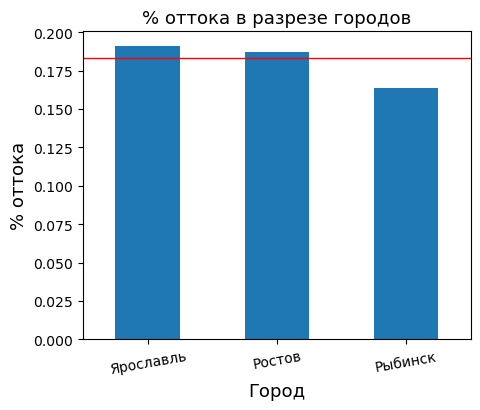

In [29]:
# построим график 
city_table.plot(x='city', y='% оттока', kind="bar", figsize=(5,4), legend=False)                       

plt.axhline(y=churn_av, linewidth=1, color='r')
plt.xlabel('Город', fontsize=13)
plt.ylabel('% оттока', fontsize=13)
plt.xticks(rotation=10)
plt.title('% оттока в разрезе городов', fontsize=13)
plt.show()

В Ярославле и Ростове % оттока выше среднего, в Рыбинске ниже всего.  

### Гендер

In [30]:
# посмотрим на отток в разрезе гендера
gender_table = define('gender')
gender_table

,gender,% оттока,количество
0,М,0.238,4971
1,Ж,0.128,4952


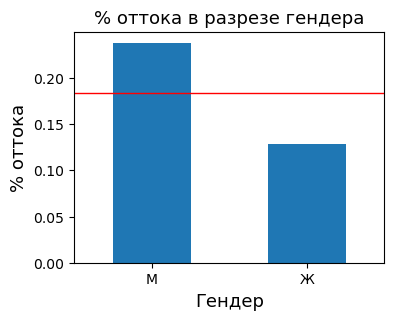

In [31]:
# построим график 
gender_table.plot(x='gender', y='% оттока', kind='bar', figsize=(4,3), legend=False)                       

plt.axhline(y=churn_av, linewidth=1, color='r')
plt.xlabel('Гендер', fontsize=13)
plt.ylabel('% оттока', fontsize=13)
plt.xticks(rotation=360)
plt.title('% оттока в разрезе гендера', fontsize=13)
plt.show()

Видимо женщины более лояльные клиенты, в то время как доля отточных клиентов среди мужчин около 23.7%.

### Количество продуктов

In [32]:
prod_table = define('products')
prod_table

,products,% оттока,количество
0,4,0.633,474
1,5,0.421,19
2,3,0.289,1029
3,2,0.192,5095
4,1,0.071,3306


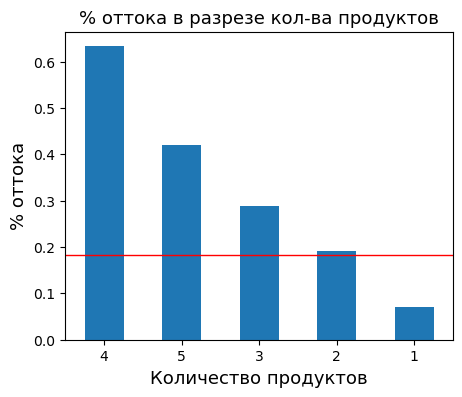

In [33]:
# построим график 
prod_table.plot(x='products', y='% оттока', kind='bar', figsize=(5,4), legend=False)                       

plt.axhline(y=churn_av, linewidth=1, color='r')
plt.xlabel('Количество продуктов', fontsize=13)
plt.ylabel('% оттока', fontsize=13)
plt.xticks(rotation=360)
plt.title('% оттока в разрезе кол-ва продуктов', fontsize=13)
plt.show()

Среди клиентов с 2 и больше продуктами % оттока выше среднего. Среди клиентов с 1 одним продуктом - около 7%. 

In [34]:
# посчитаем средний отток среди клиентов в этом диапазоне 
print('Средний отток -', round(df[df['products'] > 2]['churn'].mean() * 100, 2), '%')

Средний отток - 39.75 %


### Последняя активность

In [35]:
activity_table = define('last_activity')
activity_table.iloc[0,0] = 'активный'
activity_table.iloc[1,0] = 'не активный'
activity_table

,last_activity,% оттока,количество
0,активный,0.246,5194
1,не активный,0.114,4729


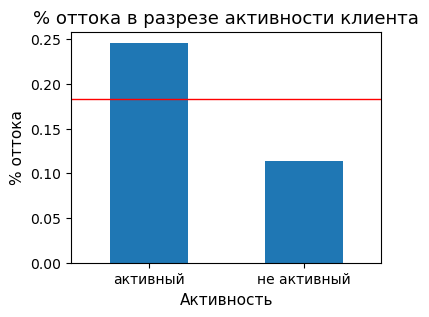

In [36]:
# построим график 
activity_table.plot(x='last_activity', y='% оттока', kind='bar', figsize=(4,3), legend=False)                       

plt.axhline(y=churn_av, linewidth=1, color='r')
plt.xlabel('Активность', fontsize=11)
plt.ylabel('% оттока', fontsize=11)
plt.xticks(rotation=360)
plt.title('% оттока в разрезе активности клиента', fontsize=13)
plt.show()

Среди активных клиентов отточных больше. Возможно у активного пользователя запросы выше к банку, и если клиента что-то не устраивает в банке, он более склонен сменить банк.

### Кредитная карта

In [37]:
card_table = define('credit_card')
card_table.iloc[0,0] = 'нет'
card_table.iloc[1,0] = 'есть'
card_table

,credit_card,% оттока,количество
0,нет,0.257,3175
1,есть,0.149,6748


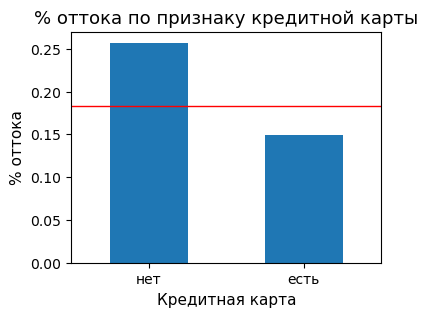

In [38]:
# построим график 
card_table.plot(x='credit_card', y='% оттока', kind='bar', figsize=(4,3), legend=False)                       

plt.axhline(y=churn_av, linewidth=1, color='r')
plt.xlabel('Кредитная карта', fontsize=11)
plt.ylabel('% оттока', fontsize=11)
plt.xticks(rotation=360)
plt.title('% оттока по признаку кредитной карты', fontsize=13)
plt.show()

Клиенты с кредитной картой менее склонны менять банк, скорее всего наличие задолженности делает их более лояльными. 

### Собственность

In [39]:
equity_table = define('equity')
equity_table

,equity,% оттока,количество
0,9,0.538,13
1,7,0.468,79
2,6,0.360,161
3,8,0.353,17
4,5,0.302,1910
5,4,0.252,1841
6,3,0.210,1531
7,2,0.159,1046
8,1,0.121,771
9,0,0.035,2554


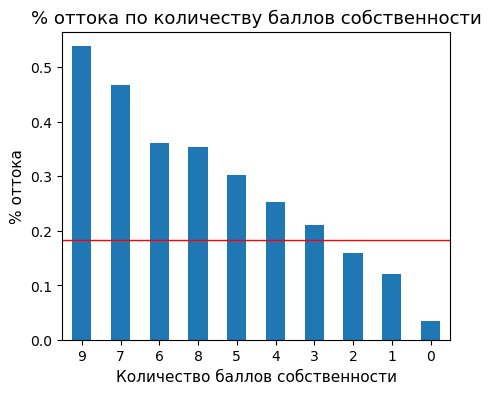

In [40]:
# построим график 
equity_table.plot(x='equity', y='% оттока', kind='bar', figsize=(5,4), legend=False)                       

plt.axhline(y=churn_av, linewidth=1, color='r')
plt.xlabel('Количество баллов собственности', fontsize=11)
plt.ylabel('% оттока', fontsize=11)
plt.xticks(rotation=360)
plt.title('% оттока по количеству баллов собственности', fontsize=13)
plt.show()

Судя по графику есть прямая зависимость между баллами собственности и верояностью оттока, чем выше балл - тем более вероятен уход.

In [41]:
# посчитаем средний отток среди клиентов в этом диапазоне 
print('Средний отток -', round(df[df['equity'] > 2]['churn'].mean() * 100, 2), '%')

Средний отток - 26.46 %


In [42]:
# посчитаем коэффицент корреляции
df['equity'].corr(df['churn'])

0.2701372043291698

Есть слабая корреляция, коэффициент подтверждает, что есть слабая зависимость.

### Баланс на счете

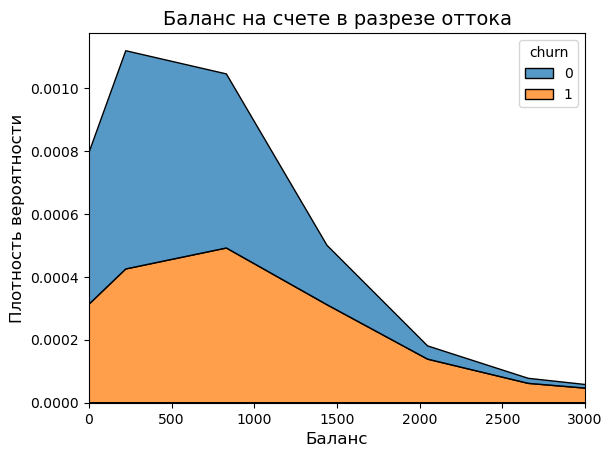

In [43]:
# построим график плотности
sns.kdeplot(data=df, x='balance', hue='churn', common_norm=False, multiple='stack')
plt.title('Баланс на счете в разрезе оттока', fontsize=14)
plt.xlabel('Баланс', fontsize=12)
plt.ylabel('Плотность вероятности', fontsize=12)
plt.xlim(0,3000)
plt.show()

Среди оставшихся - медиана по балансу около 450 тыс руб, среди отточных - медиана по балансу около 750 тыс руб.

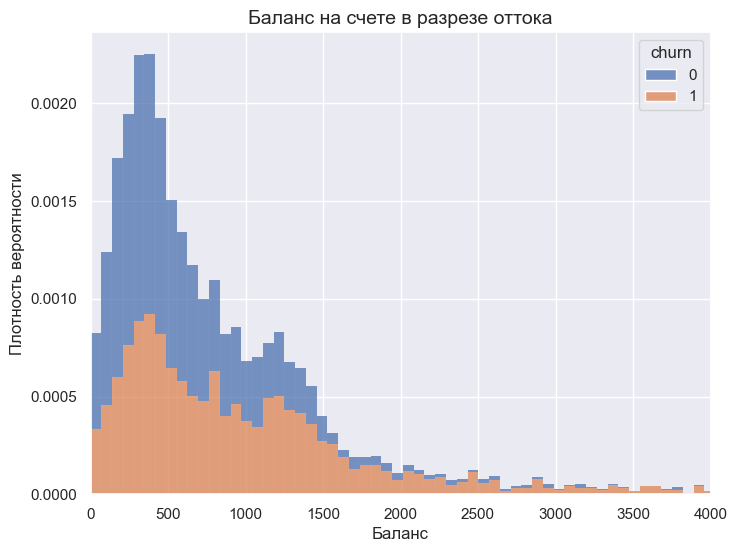

In [44]:
# построим гистограмму
sns.set(rc={"figure.figsize":(8, 6)})
sns.histplot(data=df, x='balance', hue='churn', stat='density', common_norm=False, multiple='stack')
plt.title('Баланс на счете в разрезе оттока', fontsize=14)
plt.xlabel('Баланс', fontsize=12)
plt.ylabel('Плотность вероятности', fontsize=12)
plt.xlim(0,4000)
plt.show()

Среди отточных - достаточное количество клиентов с балансом около 1250 тыс руб на счете, среди оставшихся в основном клиенты с балансом около 500 тыс руб. 

In [45]:
# посчитаем средний отток среди клиентов в этом диапазоне 
print('Средний отток -', round(df[df['balance'] > 750]['churn'].mean() * 100, 2), '%')

Средний отток - 34.96 %


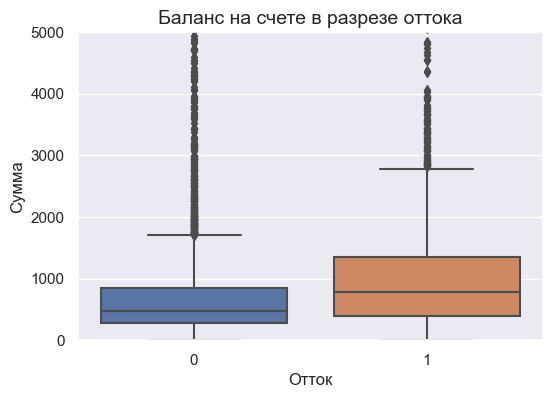

In [46]:
# пострим боксплот
sns.set(rc={"figure.figsize":(6, 4)})
sns.boxplot(x='churn', y='balance', data=df)
plt.title('Баланс на счете в разрезе оттока', fontsize=14)
plt.xlabel('Отток', fontsize=12)
plt.ylabel('Сумма', fontsize=12)
plt.ylim(0, 5000)
plt.show()

Для клиентов склонных к оттоку - медиана, верхний квартиль и максимальное значение выше. 

In [47]:
# посчитаем коэффицент корреляции
df['balance'].corr(df['churn'])

0.08570834043288612

Корреляции нет, сильной зависимости нет, единственное можем сказать, что в среднем у отточных клиентов больше средств на счете. 

### Заработная плата клиента

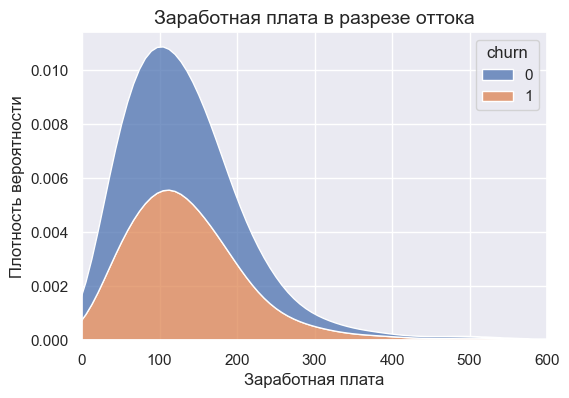

In [48]:
# построим график плотности
sns.kdeplot(data=df, x='est_salary', hue='churn', common_norm=False, multiple='stack')
plt.title('Заработная плата в разрезе оттока', fontsize=14)
plt.xlabel('Заработная плата', fontsize=12)
plt.ylabel('Плотность вероятности', fontsize=12)
plt.xlim(0,600)
plt.show()

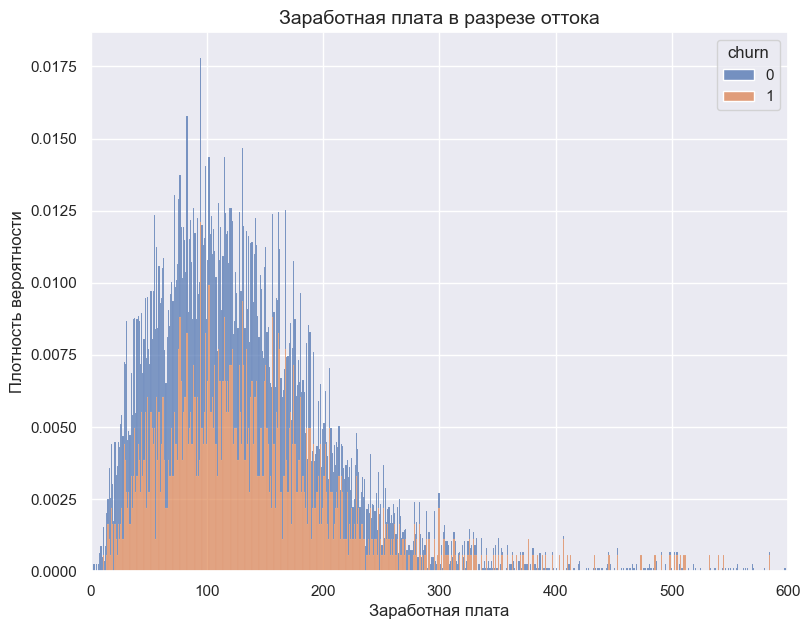

In [49]:
# построим гистограмму
sns.set(rc={"figure.figsize":(9, 7)})
sns.histplot(data=df, x='est_salary', hue='churn', stat='density', common_norm=False, multiple='stack', bins = 1394)
plt.title('Заработная плата в разрезе оттока', fontsize=14)
plt.xlabel('Заработная плата', fontsize=12)
plt.ylabel('Плотность вероятности', fontsize=12)
plt.xlim(0,600)
plt.show()

Распределение зарплат одинаково в обеих группах с пиком на уровне 100 тыс руб. 

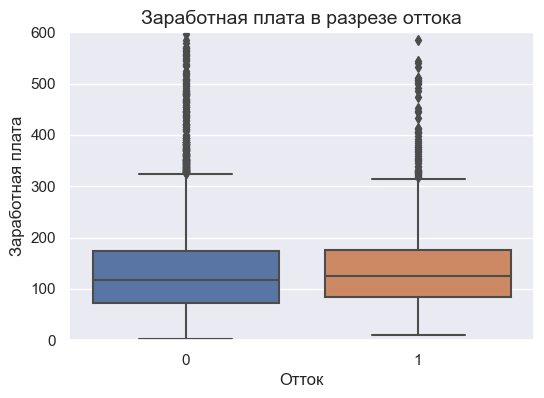

In [50]:
# пострим боксплот
sns.set(rc={"figure.figsize":(6, 4)})
sns.boxplot(x='churn', y='est_salary', data=df)
plt.title('Заработная плата в разрезе оттока', fontsize=14)
plt.xlabel('Отток', fontsize=12)
plt.ylabel('Заработная плата', fontsize=12)
plt.ylim(0, 600)
plt.show()

Статитистики примерно на одном уровне.

In [51]:
df['est_salary'].corr(df['churn'])

0.0015801227197664589

Коэффициент очень низкий, судя по графикам и коэффициенту корреляции нет. 

### Кредитный скоринг

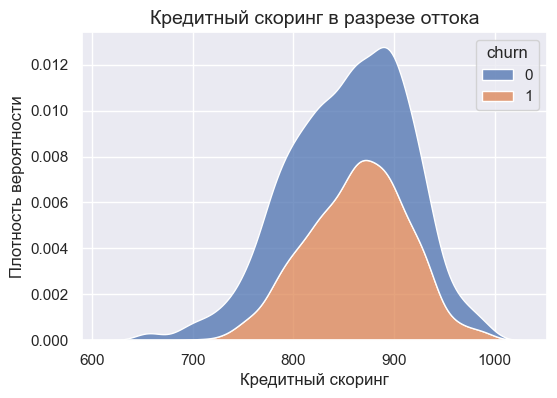

In [52]:
# построим график плотности
sns.kdeplot(data=df, x='score', hue='churn', common_norm=False, multiple='stack')
plt.title('Кредитный скоринг в разрезе оттока', fontsize=14)
plt.xlabel('Кредитный скоринг', fontsize=12)
plt.ylabel('Плотность вероятности', fontsize=12)
plt.show()

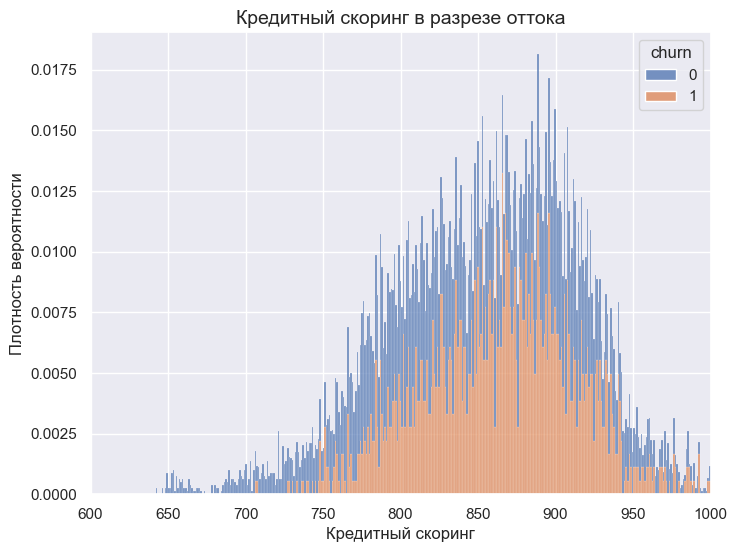

In [53]:
# построим гистограмму
sns.set(rc={"figure.figsize":(8, 6)})
sns.histplot(data=df, x='score', hue='churn', stat='density', common_norm=False, multiple='stack', bins=359)
plt.title('Кредитный скоринг в разрезе оттока', fontsize=14)
plt.xlabel('Кредитный скоринг', fontsize=12)
plt.ylabel('Плотность вероятности', fontsize=12)
plt.xlim(600,1000)
plt.show()

Среди отточных клиентов скоринг от 850 до 900 у большей части, у оставшихся клиентов скоринг в среднем чуть повыше - около 900. 

In [54]:
# посчитаем средний отток среди клиентов в этом диапазоне скоринга
print('Средний отток -', round(df[(df['score'] > 850) & (df['score'] < 900)]['churn'].mean() * 100, 2), '%')

Средний отток - 26.77 %


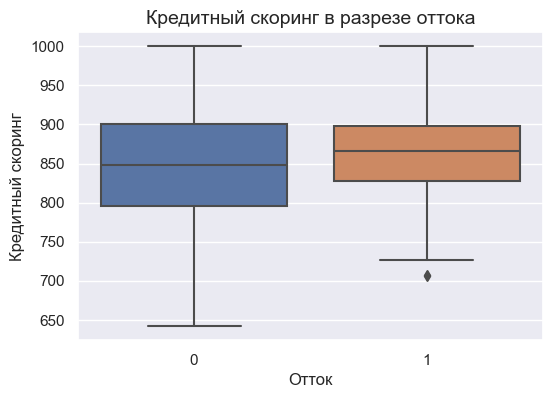

In [55]:
# пострим боксплот
sns.set(rc={"figure.figsize":(6, 4)})
sns.boxplot(x='churn', y='score', data=df)
plt.title('Кредитный скоринг в разрезе оттока', fontsize=14)
plt.xlabel('Отток', fontsize=12)
plt.ylabel('Кредитный скоринг', fontsize=12)
plt.show()

У отточных клиентов - мин значение больше, медиана - чуть больше, нижний квартиль также чуть больше. 

In [56]:
df['score'].corr(df['churn'])

0.10605452032640086

Есть слабая корреляция, чем выше скоринг, тем выше вероятность оттока. 

### Возраст

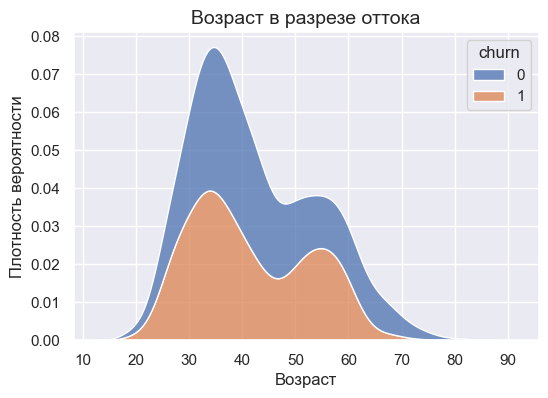

In [57]:
# построим график плотности
sns.kdeplot(data=df, x='age', hue='churn', common_norm=False, multiple='stack')
plt.title('Возраст в разрезе оттока', fontsize=14)
plt.xlabel('Возраст', fontsize=12)
plt.ylabel('Плотность вероятности', fontsize=12)
plt.show()

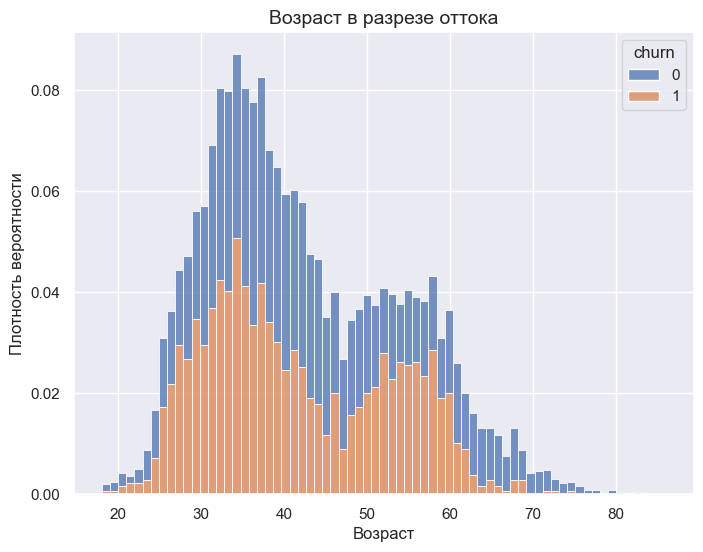

In [58]:
# построим гистограмму
sns.set(rc={"figure.figsize":(8, 6)})
sns.histplot(data=df, x='age', hue='churn', stat='density', common_norm=False, multiple='stack', bins=69)
plt.title('Возраст в разрезе оттока', fontsize=14)
plt.xlabel('Возраст', fontsize=12)
plt.ylabel('Плотность вероятности', fontsize=12)
plt.show()

Судя по графику среди отточных больше тех кому около 55 лет по сравнению с остающимися клиентами. В обеих выборках преимущественно клиенты около 35 лет. 

In [59]:
# посчитаем средний отток среди клиентов в этом диапазоне скоринга
print('Средний отток -', round(df[(df['age'] > 50)&(df['age'] < 60)]['churn'].mean() * 100, 2), '%')

Средний отток - 28.14 %


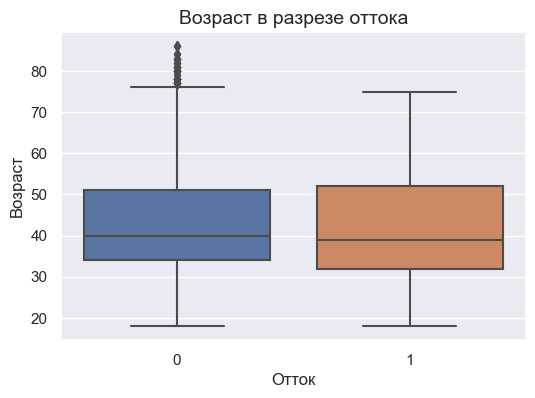

In [60]:
# пострим боксплот
sns.set(rc={"figure.figsize":(6, 4)})
sns.boxplot(x='churn', y='age', data=df)
plt.title('Возраст в разрезе оттока', fontsize=14)
plt.xlabel('Отток', fontsize=12)
plt.ylabel('Возраст', fontsize=12)
plt.show()

Медиана на одном уровне, нижний квартиль чуть меньше, верхний квартиль чуть больше. Макс и мин значения примерно на одном уровне. Среди остающихся клиентов много выбросов по возрасту, видимо пожилые люди менее склонны менять банк. 

In [61]:
df['age'].corr(df['churn'])

-0.050415242992877744

Корреляции нет. Возможно зависимость нелинейная, некоторые возрастные сегменты более склонны сменить банк, другие сегменты наоборот.

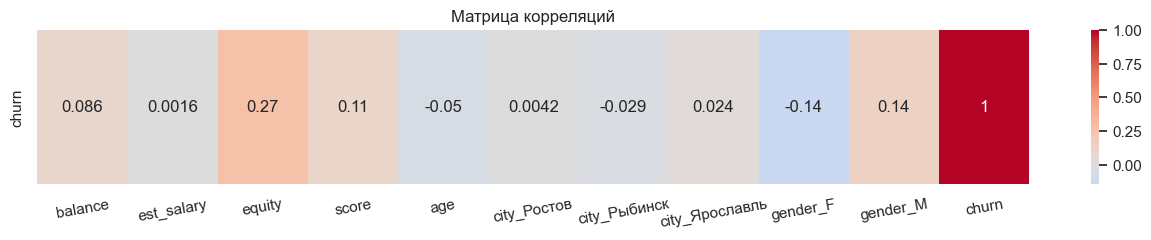

In [62]:
# выведем график со всеми корреляциями
fig, ax = plt.subplots(figsize=(16, 2))
features = ['balance', 'est_salary', 'equity', 'score', 'age', 'city_Ростов', 'city_Рыбинск', 'city_Ярославль', 
            'gender_F', 'gender_M','churn']

matrix = df[features].corr()['churn'].T

sns.heatmap(pd.DataFrame(matrix).T, cmap='coolwarm', center=0, annot=True)
plt.title('Матрица корреляций')
plt.xticks(rotation=10)
plt.show()

Слабая корреляция - equity, score, gender_F (отрицательная), gender_M.
Корреляции с другими признаками нет. 

### Анализ портретов клиентов в разрезе оттока

In [63]:
# делаем свобную таблицу, где посмотрим на средние показатели в разрезе оттока
portrait = df.pivot_table(columns='churn', aggfunc={'age':'median', 
                                                    'est_salary':'median',
                                                    'equity':'median', 
                                                    'products':'median',
                                                    'balance':'median', 
                                                    'city_Ростов':'median', 'city_Рыбинск':'median', 'city_Ярославль':'median', 
                                                    'gender_F':'median', 'gender_M':'median',
                                                    'last_activity':'median',  
                                                    'credit_card':'median'}).round(2).reset_index()

portrait['Относительная разница'] = portrait[1] - portrait[0]
portrait.columns = ['Параметр', 'Не отток', 'Отток', 'Относительная разница']
portrait

,Параметр,Не отток,Отток,Относительная разница
0,age,40.00,39.00,-1.00
1,balance,475.38,783.91,308.53
2,city_Ростов,0.00,0.00,0.00
3,city_Рыбинск,0.00,0.00,0.00
4,city_Ярославль,1.00,1.00,0.00
5,credit_card,1.00,1.00,0.00
6,equity,3.00,4.00,1.00
7,est_salary,118.25,125.41,7.16
8,gender_F,1.00,0.00,-1.00
9,gender_M,0.00,1.00,1.00


Наибольшая разница в балансе на счете - около 308 тыс руб, зарплата у отточных в среднем больше на около 7 тыс руб, также больше в среднем продуктов и баллов собственности.

## 5. Статистический анализ (тестирование гипотез)
- формулирование гипотез 
- проверка гипотез 

Будем применять t-тест для сравнения клиентов: 
- Оставшиеся и отточные клиенты не зависят друг от друга
- Ввиду больших размеров выборок распределение Стьюдента стремится к нормальному
- Так как выборки разного размера и предполагаем, что дисперсии разные, укажим equal_var = False. 

In [64]:
# выделим выборки
df_0 = df.query('churn == 0')
df_1 = df.query('churn == 1')

In [65]:
# выполним тест Левена, чтоб проверить равенство дисперсий (проверим на зарплате)
st.levene(df_0['est_salary'], df_1['est_salary'], center='median')

alpha = .05

P-value меньше alpha, делаем вывод, что дисперсии не равны. 

### 1 гипотеза

Проверка гипотезы: доходы между отточными и оставшимися клиентами различаются.

```
H_0: Доход (est_salary) отточных клиентов = Доход (est_salary) оставшихся клиентов 
H_a: Доход (est_salary) отточных клиентов ≠ Доход (est_salary) оставшихся клиентов 
alpha = 0.05
```

In [66]:
samp1 = df[df['churn'] == 1]['est_salary']
samp2 = df[df['churn']  == 0]['est_salary']
results = st.ttest_ind(samp1, samp2, equal_var=False) # results = вызов метода для проверки гипотезы

alpha = .05 # alpha = задаем значение уровня значимости

sign = results.pvalue # вывод значения p-value на экран 
sign    

0.8626784591490468

In [67]:
if results.pvalue < alpha: # условный оператор с выводом строки с ответом
    print('Отвергаем нулевую гипотезу')
else: 
    print('Не получилось отвергнуть нулевую гипотезу')   

Не получилось отвергнуть нулевую гипотезу


Делаем вывод, что нет статистически значимых различий между доходами клиентов. Даже если у отточных клиентов медианная зарплата выше на 7 тыс руб, это не значительная разница. 

### 2 гипотеза 

Проверка гипотезы: кредитный скоринг между отточными и оставшимися клиентами различается.

```
H_0: Кредитный скоринг (score) отточных клиентов = Кредитный скоринг (score) оставшихся клиентов 
H_a: Кредитный скоринг (score) отточных клиентов ≠ Кредитный скоринг (score оставшихся клиентов 
alpha = 0.05
```

In [68]:
samp1 = df[df['churn'] == 1]['score']
samp2 = df[df['churn']  == 0]['score']
results = st.ttest_ind(samp1, samp2, equal_var=False) # results = вызов метода для проверки гипотезы

alpha = .05 # alpha = задаем значение уровня значимости

sign = results.pvalue # вывод значения p-value на экран 
sign  

2.183635757413355e-37

In [69]:
if results.pvalue < alpha: # условный оператор с выводом строки с ответом
    print('Отвергаем нулевую гипотезу')
else: 
    print('Не получилось отвергнуть нулевую гипотезу')   

Отвергаем нулевую гипотезу


Есть статистически значимые различия между выборками в разрезе кредитного скоринга. 

### 3 гипотеза

Проверка гипотезы: количество продуктов между отточными и оставшимися клиентами различается.

```
H_0: Количество продуктов (products) отточных клиентов = Количество продуктов (products) оставшихся клиентов 
H_a: Количество продуктов (products) отточных клиентов ≠ Количество продуктов (products) оставшихся клиентов 
alpha = 0.05
```

In [70]:
samp1 = df[df['churn'] == 1]['products']
samp2 = df[df['churn'] == 0]['products']
results = st.ttest_ind(samp1, samp2, equal_var=False) # results = вызов метода для проверки гипотезы

alpha = .05 # alpha = задаем значение уровня значимости

sign = results.pvalue # вывод значения p-value на экран 
sign 

9.413327765189615e-139

In [71]:
if results.pvalue < alpha: # условный оператор с выводом строки с ответом
    print('Отвергаем нулевую гипотезу')
else: 
    print('Не получилось отвергнуть нулевую гипотезу')  

Отвергаем нулевую гипотезу


Есть статистические различия между количеством продуктов в разрезе отточности. 

## 6. Промежуточные итоги 
- выделить стратегические показатели, влияющие на отток

Выделим следующие группы клиентов наиболее склонные к оттоку по признакам: 
```
    - кредитный скоринг от 850 до 900    
    - баланс на счете больше 750 тыс руб
    - город Ростов и Ярославль
    - гендер - М 
    - коэффициент собственности больше 2
    - возраст от 50 до 60 лет 
    - количество продуктов больше 2 
    - активный клиент
    - без кредитной карты 
```

<div class="alert alert-success">
<h2> Комментарий тимлида <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Выделили признаки, влияющие на отток, и их значения - отлично!

## 7. Сегментация
- формирование отточных сегментов по минимум 2 признакам

На основе исследовательского анализа данных и тестирования гипотез сформируем сегменты по 2 признакам, включающие наибольший процент оттока клиентов.

### 1 сегмент: клиенты из Ярославля с количеством продуктов больше 2

In [72]:
print('Размер сегмента -', len(df[(df['city'] == 'Ярославль') & (df['products'] > 2)]))
print('Средний отток -', round(df[(df['city'] == 'Ярославль') & (df['products'] > 2)]['churn'].mean() * 100, 2), '%')
print('Количество отточных клиентов в сегменте - ', len(df[(df['city'] == 'Ярославль') & (df['products'] > 2) & 
                                                           (df['churn'] == 1)]))

Размер сегмента - 1098
Средний отток - 40.16 %
Количество отточных клиентов в сегменте -  441


### 2 сегмент: клиенты возраста 50-60 лет с коэффициентом собственности больше 2

In [73]:
print('Размер сегмента -', len(df[(df['age'] > 50) & (df['age'] < 60) & (df['equity'] > 2)]))
print('Средний отток -', round(df[(df['age'] > 50) & (df['age'] < 60) & (df['equity'] > 2)]['churn'].mean() * 100, 2), '%')
print('Количество отточных клиентов в сегменте - ', len(df[(df['age'] > 50) & (df['age'] < 60) & (df['equity'] > 2) & 
                                                           (df['churn'] == 1)]))

Размер сегмента - 818
Средний отток - 37.9 %
Количество отточных клиентов в сегменте -  310


### 3 сегмент: активные клиенты без кредитной карты 

In [74]:
print('Размер сегмента -', len(df[(df['last_activity'] == 1) & (df['credit_card'] == 0)]))
print('Средний отток -', round(df[(df['last_activity'] == 1) & (df['credit_card'] == 0)]['churn'].mean() * 100, 2), '%')
print('Количество отточных клиентов в сегменте - ', len(df[(df['last_activity'] == 1) & (df['credit_card'] == 0) &
                                                           (df['churn'] == 1)]))

Размер сегмента - 1740
Средний отток - 35.17 %
Количество отточных клиентов в сегменте -  612


### 4 сегмент: клиенты-мужчины с балансом на счете более 750 тыс руб

In [75]:
print('Размер сегмента -', len(df[(df['balance'] > 750) & (df['gender'] == 'М')]))
print('Средний отток -', round(df[(df['balance'] > 750) & (df['gender'] == 'М')]['churn'].mean() * 100, 2), '%')
print('Количество отточных клиентов в сегменте - ', len(df[(df['balance'] > 750) & (df['gender'] == 'М') &
                                                           (df['churn'] == 1)]))

Размер сегмента - 1369
Средний отток - 45.22 %
Количество отточных клиентов в сегменте -  619


## 8. Выводы, рекомендации
- итоговые рекомендации по результатам исследования для маркетингового отдела по выбранным сегментам, приоритизация сегментов

В этом проекте мы анализировали клиентов Метанпромбанка, работали c данными о параметрах клиентов, их активности и взаимодействии с банком и его продуктами, чтобы в итоге определить потенциальные сегменты для таргетирования маркетинговым отделом для снижения оттока клиентов. 

Предстоит приоритизировать сегменты, можно это сделать в зависимости от размера сегмента или уровня оттока в сегменте. 
Если говорить о размере, то в первую очередь можно выбрать 3 и 4 сегменты, 1745 и 1370 клиентов соответственно.
Если взять за цель уровень оттока, то следует выбрать 4 и 1 сегменты, 45.18% и 40.13% соответственно. 
Если на текущий момент нет возможности таргетировать большие сегменты ввиду отсутствия автоматизированной системы рассылки, можно выбрать 2 и 1 сегменты, 819 и 1099 клиентов соответсвенно, если нужно дальше снизить размер сегментов, можно добавить признаки или скорректировать диапазон выбранных признаков. 

Конкретно про каждый сегмент:

1 сегмент: клиенты из Ярославля с количеством продуктов больше 2 (двух)

В Ярославле большая часть клиентов, средний уровень оттока - около 19%, чтобы не таргетировать всех, возьмем тех, кто пользуется
2 и больше продуктами, так как отток растет с количеством продуктов. Клиенты, которые например пользуются дебетовой картой и накопительным счетом, скорее всего рассматривают Метанпромбанк как основной и не склонны держать несколько открытых счетов в разных банках, и потенциально могут быть заинтересованы в других продуктах Банка. Поэтому важно таргетировать именно таких клиентов.

2 сегмент: клиенты возраста 50-60 лет с коэффициентом собственности больше 2 (двух)

Как мы выяснили, состоятельные клиенты более склонны к оттоку, эти клиенты как раз примерно этого возраста, такие клиенты больше держат на счетах, возможно пользуются премиум-обслуживанием. 

3 сегмент: активные клиенты без кредитной карты 

Клиенты из этого сегмента могут покинуть банк по разным причинам, активные клиенты заинтересованы в хорошем обслуживании и высокой привлекательности продуктов. Если их не держит задолженность по кредитной карте, ничего не стоит уйти в другой банк. 
Это могут быть лояльные клиенты, которые потенциально могут воспользоваться другими продуктами банка, например ипотечным кредитованием. 

4 сегмент: клиенты-мужчины с балансом на счете более 750 тыс руб

Клиенты-мужчины менее лояльные клиенты, чем женщины (несмотря на примерно равное количество обеих групп), особенно те, кто держат на счете 750 тыс руб и больше.
Опять-таки имеем дело с клиентами, которые могут держать на счетах большие суммы, совершать много операций, платить регулярно комиссии. Следует обратить на них внимание. 

Рекомендуем планировать маркетинговые кампании в соответствии с выводами выше. 